# PoC on German Credit

In [205]:
%reload_ext autoreload
%autoreload 2

## Data Processing

In [206]:
import pandas as pd

data = pd.read_csv('data/german_credit.csv')
# data = data.drop('Checking account', axis=1)
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Model Training

In [207]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

target_name = 'Risk'

# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Split the data into features and target variable
X = data.drop(target_name, axis=1)
y = data[target_name]

# Split the data into training and testing sets
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=0.7, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)


In [208]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train the logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy = {accuracy}')
print(report)


Accuracy = 0.6833333333333333
              precision    recall  f1-score   support

           0       0.67      0.27      0.39        22
           1       0.69      0.92      0.79        38

    accuracy                           0.68        60
   macro avg       0.68      0.60      0.59        60
weighted avg       0.68      0.68      0.64        60



C:\Users\leiyo\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Fairness Checking (Naive)

In [209]:
# import numpy as np

# sensitive_attribute = 'Sex'

# # Extract the coefficient for the "sex" feature
# sex_coefficient = model.coef_[0][X.columns.get_loc(sensitive_attribute)]

# # Check the distribution of predictions for different sexes
# predicted_proba = model.predict_proba(X_test)[:, 1]
# X_test['predicted_proba'] = predicted_proba
# X_test['actual'] = y_test

# # Group by sex
# grouped_by_sex = X_test.groupby(sensitive_attribute).agg({
#     'predicted_proba': ['mean'],
#     'actual': ['mean']
# })

# sex_coefficient, grouped_by_sex


## DataMatcher Module Test

In [210]:
from src.matching import NearestNeighborDataMatcher

In [211]:
X_observe = X_train


In [212]:
matching = NearestNeighborDataMatcher(X_labeled=X_observe, X_unlabeled=X_unlabeled).match(n_neighbors=2)

## Fairness Attribution Module Test

In [213]:
from src.attribution import FairnessExplainer

In [214]:
sen_att_name = ["Sex"]

sen_att = [X_observe.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)


In [215]:
fairness_explainer = FairnessExplainer(model=model, sen_att=sen_att, priv_val=priv_val, unpriv_dict=unpriv_dict)

In [216]:
fairness_shap_values = fairness_explainer.shap_values(
    X=X_observe.values,
    X_baseline=X_unlabeled.values,
    matching=matching,
    sample_size=1000,
    shap_sample_size="auto",
)

C:\Users\leiyo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\leiyo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\leiyo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\leiyo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\leiyo\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warni

In [217]:
import shap

# print the JS visualization code to the notebook
shap.initjs()

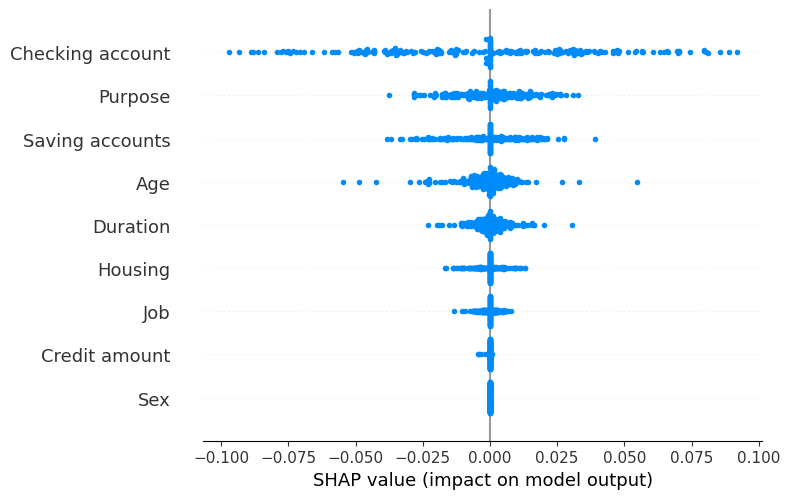

In [218]:
shap.summary_plot(fairness_shap_values, feature_names=X.columns)

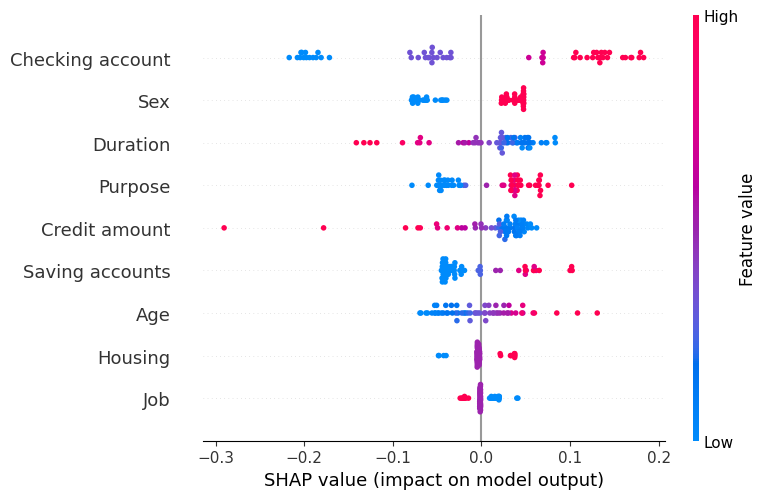

In [222]:
# Create a SHAP explainer
shap_explainer = shap.Explainer(lambda x: model.predict_proba(x)[:, 1], X_train)

# Calculate SHAP values
shap_values = shap_explainer(X_test)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, feature_names=X.columns)

In [221]:
shap_values.shape

(60, 9)